In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install deepinv

In [ ]:
import os
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from skimage import data
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
import json
import deepinv as dinv
from skimage.transform import iradon

# Import UNet file
sys.path.append('/content/drive/MyDrive/MScProject')

from Model_arch import UNet

In [ ]:
class OperatorFunction(torch.autograd.Function):
    @staticmethod
    def forward(ctx, operator, x):
        # ctx.operator saved for backward
        ctx.operator = operator
        # call the DeepInv forward operator A
        with torch.no_grad():
            out = operator.A(x)
        # no need to save x unless A is nonlinear
        return out

    @staticmethod
    def backward(ctx, grad_output):
        # in the backward pass, apply the adjoint A_adjoint
        operator = ctx.operator
        grad_input = operator.A_adjoint(grad_output)
        # first returned None says “no gradient for operator”
        return None, grad_input

class OperatorModule(torch.nn.Module):
    def __init__(self, operator):
        super().__init__()
        self.operator = operator

    def forward(self, x):
        # call our custom Function
        return OperatorFunction.apply(self.operator, x)

    def A_dagger(self, y):
        # if you ever want to call the adjoint directly
        return self.operator.A_dagger(y)


In [ ]:
class EarlyStopWMV:
    """
    Sliding‐Window (size = W) Moving Variance early‐stopper.
      • size:     window length W
      • patience: how many consecutive iterations without variance‐improvement
                  before stopping
    """
    def __init__(self, size, patience):
        self.size       = size
        self.patience   = patience
        self.wait_count = 0
        self.best_score = float('inf')  # “smallest windowed‐variance seen so far”
        self.best_epoch = 0
        self.buffer     = []            # will hold up to `size` NumPy arrays [C,H,W]
        self.stop       = False

    def update_buffer(self, cur_img):
        """
        Append cur_img (NumPy [C,H,W]) to FIFO buffer.
        If buffer > W, pop the oldest element.
        """
        self.buffer.append(cur_img.copy())
        if len(self.buffer) > self.size:
            self.buffer.pop(0)

    def compute_variance(self):
        """
        Once buffer is full (len(buffer)==W), compute:
          ave_img   = mean(buffer, axis=0)               # shape [C,H,W]
          var_list  = [ || x_i - ave_img ||_F^2  for i ]  # each scalar
          cur_var   = average of var_list
        Return cur_var as a float.
        """
        X = np.stack(self.buffer, axis=0).astype(np.float32)  # shape (W, C, H, W)
        ave_img = X.mean(axis=0)                              # shape [C,H,W]
        diffs   = X - ave_img                                 # shape (W, C, H, W)
        # Frobenius norm squared of each slice:
        var_per_frame = (diffs.reshape(self.size, -1) ** 2).sum(axis=1)  # shape (W,)
        cur_var = float(var_per_frame.mean())
        return cur_var

    def check_stop(self, cur_var, cur_epoch):
        """
        If cur_var < best_score:
          • best_score = cur_var
          • best_epoch = cur_epoch
          • wait_count  = 0
        Else:
          • wait_count += 1
          • if wait_count >= patience: self.stop = True
        Returns self.stop (True if we should break).
        """
        if cur_var < self.best_score:
            self.best_score = cur_var
            self.best_epoch = cur_epoch
            self.wait_count = 0
        else:
            self.wait_count += 1
            if self.wait_count >= self.patience:
                self.stop = True
        return self.stop


def nabla(x):
        r"""
        Applies the finite differences operator associated with tensors of the same shape as x.
        """
        b, c, h, w = x.shape
        u = torch.zeros((b, c, h, w, 2), device=x.device).type(x.dtype)
        u[:, :, :-1, :, 0] = u[:, :, :-1, :, 0] - x[:, :, :-1]
        u[:, :, :-1, :, 0] = u[:, :, :-1, :, 0] + x[:, :, 1:]
        u[:, :, :, :-1, 1] = u[:, :, :, :-1, 1] - x[..., :-1]
        u[:, :, :, :-1, 1] = u[:, :, :, :-1, 1] + x[..., 1:]
        return u

def save_image(output_tensor, iteration, lambd):
    """
    Save a [1,3,H,W] torch tensor (float in [0,1]) as outputs/output_{iteration}.png.
    """
    out = output_tensor.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # [H,W,3]
    out = np.clip(out, 0, 1)
    out = (out * 255).astype(np.uint8)
    plt.imsave(f"outputs/CT/output_{iteration}_lambda_{lambd}.png", out)

def calculate_psnr(original, denoised):
    """
    Compute PSNR between two NumPy arrays in [0,1], same shape.
    """
    eps = 1e-10
    mse = np.mean((original - denoised) ** 2)
    if mse == 0:
        return 100
    max_pixel = np.max(original)
    return 10 * np.log10(((max_pixel**2) + eps) / mse)


In [ ]:
def train_test_model(y, epochs, physics , gt_np ,device = torch.device("cpu") , window= 100, patience= 10000, lambd = 2e-5):

  H, W = gt_np.shape
  input = torch.randn(1, 1, H, W, device=device) * 0.1  # random noise tensor [1,1,H,W]

  model = UNet(in_ch=1, out_ch=1).to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, eps = 1e-6)
  loss_fn   = nn.MSELoss()

  epochs = epochs
  psnrs_gt = []                   # will hold (epoch, PSNR(gt→recon))
  var_history = [None] * epochs   # store EMV at each epoch

  # Instantiate ES‐WMV early‐stopper (sliding‐window size=W, patience=P)
  W = window
  P = patience

  es_wmv = EarlyStopWMV(size=W, patience=P)
  best_output = None

  model.train()
  for epoch in range(epochs):
      # ——————————————————————————————
      # 3) DIP forward + backward update
      # ——————————————————————————————
      recon = model(physics.A(input))      # [1,1,H,W]


      y_pred = physics.A(recon)
      mse_loss = loss_fn(y_pred, y)  # MSE loss between noisy and predicted

      grad_u = nabla(recon)
      Dx = grad_u[..., 0]
      Dy = grad_u[..., 1]
      mag = torch.sqrt((Dx**2 + Dy**2).sum(dim=1) + 1e-10) # avoid division by zero
      TV_val = mag.mean()
      lambda_tv = lambd # TV regularization weight

      # Calculate total loss: MSE + TV regularization

      loss = mse_loss + lambda_tv * TV_val  # MSE + TV regularization

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      print(f"Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, MSE: {mse_loss.item():.4f} , TV: {TV_val:.4f}")

      # ——————————————————————————————
      # 4) Compute & store PSNR every epoch
      # ——————————————————————————————
      rec_np = recon.squeeze().detach().cpu().numpy()

      psnr_gt = calculate_psnr(gt_np, rec_np)
      psnrs_gt.append((epoch, psnr_gt))

      # ——————————————————————————————
      # 5) Save a PNG every 500 epochs (unchanged)
      # ——————————————————————————————
      if epoch % 500 == 0:
          save_image(torch.cat([recon]*3, dim=1), epoch, lambd = lambd)

      # ——————————————————————————————
      # 6) ES‐EMV logic:
      #    (a) Let update_av handle epoch==0 initialisation
      #    (b) Then do check_stop, maybe record best_output, maybe break
      # ——————————————————————————————

      # 4) ES‐WMV logic: sliding‐window variance on the single‐channel recon

      # recon is [1,1,H,W], so squeeze to [H,W].
      rec_cpu = recon.squeeze().detach().cpu().numpy()  # [H,W]
      es_wmv.update_buffer(rec_cpu)

      # 4b) Once buffer is full, compute variance and check stop:
      if len(es_wmv.buffer) == W:
          cur_var = es_wmv.compute_variance()


          # store for plotting later (optional)
          var_history[epoch] = cur_var

          # Check if we should stop:
          should_stop = es_wmv.check_stop(cur_var, epoch)

          # If this step gave a brand‐new best variance, save the reconstruction:
          if es_wmv.best_epoch == epoch:
              best_output = recon.detach().cpu().clone()
              #print(f"ES‐WMV updated best_output at epoch {es_wmv.best_epoch}, windowed variance = {es_wmv.best_score:.4f}")
          # If patience has run out, break out now:
          if should_stop:
              print(f"ES‐WMV early stop at epoch {epoch}, best_epoch = {es_wmv.best_epoch}")
              break
  return recon, best_output, psnrs_gt, var_history, es_wmv

Streaming output truncated to the last 5000 lines.
Epoch [20001/25000], Loss: 0.8268, MSE: 0.8268 , TV: 0.0547
Epoch [20002/25000], Loss: 0.8617, MSE: 0.8617 , TV: 0.0542
Epoch [20003/25000], Loss: 0.8425, MSE: 0.8425 , TV: 0.0540
Epoch [20004/25000], Loss: 0.8036, MSE: 0.8036 , TV: 0.0547
Epoch [20005/25000], Loss: 0.9552, MSE: 0.9552 , TV: 0.0552
Epoch [20006/25000], Loss: 0.8308, MSE: 0.8308 , TV: 0.0540
Epoch [20007/25000], Loss: 0.8547, MSE: 0.8547 , TV: 0.0542
Epoch [20008/25000], Loss: 0.9823, MSE: 0.9823 , TV: 0.0544
Epoch [20009/25000], Loss: 0.9168, MSE: 0.9168 , TV: 0.0546
Epoch [20010/25000], Loss: 0.8554, MSE: 0.8554 , TV: 0.0541
Epoch [20011/25000], Loss: 0.7836, MSE: 0.7836 , TV: 0.0544
Epoch [20012/25000], Loss: 0.8771, MSE: 0.8771 , TV: 0.0546
Epoch [20013/25000], Loss: 0.8622, MSE: 0.8622 , TV: 0.0540
Epoch [20014/25000], Loss: 0.7731, MSE: 0.7731 , TV: 0.0543
Epoch [20015/25000], Loss: 0.8321, MSE: 0.8321 , TV: 0.0548
Epoch [20016/25000], Loss: 0.7882, MSE: 0.7882 , 

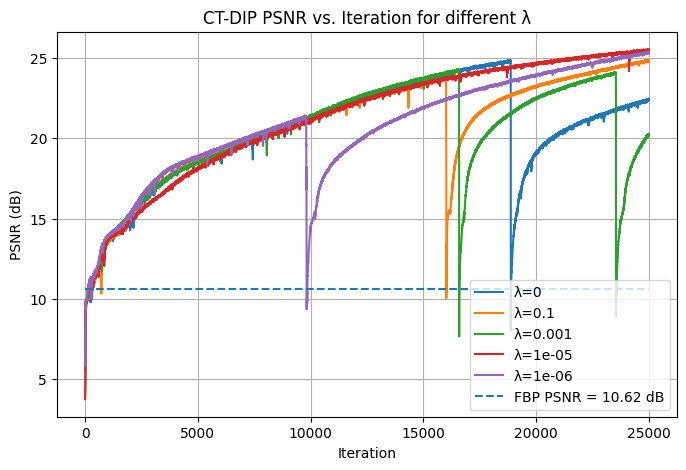

In [ ]:
if __name__ == "__main__":
  device = torch.device("cuda"if torch.cuda.is_available() else "cpu")
  print(device)
  os.makedirs("outputs/CT", exist_ok=True)
  # Load + preprocess the “astronaut” image
  image = data.astronaut()
  plt.imsave("outputs/CT/original_image.png", image)
  image = image / 255.0  # float in [0,1]

  # Resize to half dimensions (integer)
  H, W, _ = image.shape
  image = resize(image, (H // 2, W // 2), anti_aliasing=True)
  H, W, _ = image.shape

  # Plotting Dx and Dy
  x_true = torch.from_numpy(image[:,:,0]).float()[None, None].to(device)
  angles_torch = torch.linspace(0, 180, 60, dtype = torch.float32, device=device)  # 60 angles from 0 to 180 degrees

  physics_raw = dinv.physics.Tomography(
        img_width = W,
        angles = angles_torch,
        device = device,
        noise_model = dinv.physics.GaussianNoise(sigma = 0.02)
    )

  physics = OperatorModule(physics_raw)
  y = physics(x_true)
  y_np = y.squeeze().cpu().numpy().T  # [1,H,W]
  plt.figure(figsize = (6, 4))
  plt.imshow(y_np, aspect='auto', cmap='gray')
  plt.xlabel("Projection angle (degrees)")
  plt.ylabel("Detector index")
  plt.title("Sinogtram y = A(x_true) + noise")
  plt.colorbar(label="Measured intensity")
  plt.tight_layout()
  plt.savefig("outputs/CT/sinogram.png")
  plt.close()

  grad_u = nabla(x_true)  # [1,1,H,W,2]
  Dx = grad_u[0,0,...,0].cpu().numpy()  # [H,W]
  Dy = grad_u[0,0,...,1].cpu().numpy()  # [H,W]

  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,4))

  ax1.imshow(Dx, cmap='gray'); ax1.set_title('Dₓ (vertical edges)'); ax1.axis('off')
  ax2.imshow(Dy, cmap='gray'); ax2.set_title('Dᵧ (horizontal edges)'); ax2.axis('off')
  plt.tight_layout()
  plt.savefig("outputs/CT/gradients.png")
  plt.close(fig)

  gt_np  = x_true.squeeze().cpu().numpy()          # NumPy [1,H,W]

  plt.figure(figsize = (5, 5))
  plt.imshow(gt_np, cmap='gray', vmin=0, vmax=1)
  plt.axis('off')
  plt.title("X_true (ground truth)")
  plt.tight_layout()
  plt.savefig("outputs/CT/x_ground_truth.png")
  plt.close()

  y_np   = y.squeeze().cpu().numpy()
  angles_np = np.linspace(0, 180, 60, endpoint=False).astype(np.float32)
  fbp_np = iradon(y_np, theta=angles_np, filter_name='ramp', circle=True, output_size=H)
  psnr_fbp = calculate_psnr(gt_np, fbp_np)
  print(f"FBP baseline PSNR: {psnr_fbp:.2f} dB")

  lambdas = [0 , 1e-1, 1e-3, 1e-5, 1e-6]

  all_curves = []

  for lambd in lambdas:
    recon, best_output, psnrs_gt, var_history, es_wmv = train_test_model(y, 25000, physics , gt_np ,device = device , window= 100, patience= 10000, lambd = lambd )

    # ——————————————————————————————
    # 7) After training: use best_output (or fallback to last epoch)
    # ——————————————————————————————

    if best_output is not None:
      # recon_best = best_output[:, :1, ...] #[1, 1, H, W]
      save_image(best_output.repeat(1,3,1,1), f"best_epoch_{es_wmv.best_epoch}", lambd)
      gt_np = x_true.squeeze().cpu().numpy()
      rec_np = best_output.squeeze().cpu().numpy()
      print("Final CT‐DIP PSNR:", calculate_psnr(gt_np, rec_np))

    else:
      print("ES‐WMV never updated best_output; using last epoch’s output.")
      save_image(recon.repeat(1,3,1,1), "last_epoch", lambd)
      gt_np = x_true.squeeze().cpu().numpy()
      last_np = recon.squeeze().cpu().numpy()
      print("Final PSNR(gt→recon) at last epoch:",
            f"{calculate_psnr(gt_np, last_np):.2f} dB")

    all_curves.append((lambd, psnrs_gt))



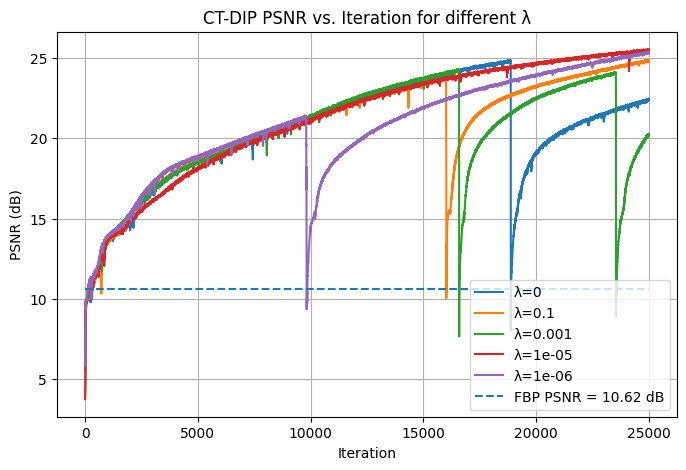

In [ ]:
# Save all of your PSNR curves:
with open("outputs/CT/psnr_gt_reco.json", "w") as f:
    json.dump(
        {
            str(l): [float(psnr) for (_, psnr) in curves]
            for l, curves in all_curves
        },
        f,
    )


# Plot them all together:
fig, ax1 = plt.subplots(figsize=(8,5))
for lambd, curves in all_curves:
    its, vals = zip(*curves)
    ax1.plot(its, vals, label=f"λ={lambd}")
ax1.hlines(psnr_fbp, 0, its[-1],
           label=f"FBP PSNR = {psnr_fbp:.2f} dB",
           linestyle="--")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("PSNR (dB)")
ax1.set_title("CT-DIP PSNR vs. Iteration for different λ")
ax1.legend()
ax1.grid(True)
plt.savefig("outputs/CT/psnr_all_lambdas.png")


In [ ]:
from google.colab import files
print("Downloading outputs...")
files.download("outputs/CT.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>